# Find ERA5 coordinates from bounding box
Script to automatically find the bounding box for a given shapefile and round this to 0.25 degrees for use in the ERA5 downloader. Assumes that the representative area covered by a given ERA5 coordinate (i.e. a grid point) extends 0.125 degrees latitude/longitude in each cardinal direction. 

See: https://confluence.ecmwf.int/display/CKB/ERA5%3A+What+is+the+spatial+reference#ERA5:Whatisthespatialreference-Visualisationofregularlat/londata

In [63]:
import math
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

#### Control file handling

In [2]:
# Easy access to control file folder
controlFolder = Path('../0_control_files')

In [3]:
# Store the name of the 'active' file in a variable
controlFile = 'control_active.txt'

In [4]:
# Function to extract a given setting from the control file
def read_from_control( file, setting ):
    
    # Open 'control_active.txt' and ...
    for line in open(file):
        
        # ... find the line with the requested setting
        if setting in line:
            break
    
    # Extract the setting's value
    substring = line.split('|',1)[1]      # Remove the setting's name (split into 2 based on '|', keep only 2nd part)
    substring = substring.split('#',1)[0] # Remove comments, does nothing if no '#' is found
    substring = substring.strip()         # Remove leading and trailing whitespace, tabs, newlines
    
    # Return this value    
    return substring

In [5]:
# Function to specify a default path
def make_default_path(suffix):
    
    # Get the root path
    rootPath = Path( read_from_control(controlFolder/controlFile,'root_path') )
    
    # Get the domain folder
    domainName = read_from_control(controlFolder/controlFile,'domain_name')
    domainFolder = 'domain_' + domainName
    
    # Specify the forcing path
    defaultPath = rootPath / domainFolder / suffix
    
    return defaultPath

#### Find spatial domain as bounding box of shapefile

In [124]:
# function to round coordinates of a bounding box to ERA5s 0.25 degree resolution
def round_coords_to_ERA5(coords):
    
    '''Assumes coodinates are an array: [lon_min,lat_min,lon_max,lat_max].
    Returns separate lat and lon vectors.'''
    
    # Extract values
    lon = [coords[0],coords[2]]
    lat = [coords[1],coords[3]]
    
    # Round to ERA5 0.25 degree resolution
    rounded_lon = [math.floor(lon[0]*4)/4, math.ceil(lon[1]*4)/4]
    rounded_lat = [math.floor(lat[0]*4)/4, math.ceil(lat[1]*4)/4]
    
    # Find if we are still in the representative area of a different ERA5 grid cell
    if lat[0] > rounded_lat[0]+0.125:
        rounded_lat[0] += 0.25
    if lon[0] > rounded_lon[0]+0.125:
        rounded_lon[0] += 0.25
    if lat[1] < rounded_lat[1]-0.125:
        rounded_lat[1] -= 0.25
    if lon[1] < rounded_lon[1]-0.125:
        rounded_lon[1] -= 0.25
    
    return rounded_lat, rounded_lon

In [14]:
# Find name and location of catchment shapefile
shp_path = read_from_control(controlFolder/controlFile, 'catchment_shp_path')
shp_name = read_from_control(controlFolder/controlFile, 'catchment_shp_name')

In [15]:
# Specify default path if needed
if shp_path == 'default':
    shp_path = make_default_path('shapefiles/catchment')
else:
    shp_path = Path(shp_path)

In [16]:
# Open the shapefile
shp = gpd.read_file(shp_path/shp_name)

In [17]:
# Get the latitude and longitude of the bounding box
bounding_box = shp.total_bounds

In [125]:
# Find the rounded bounding box
lat,lon = round_coords_to_ERA5(bounding_box)

In [126]:
# Print in ERA5 format
print('Specify coordinates as {}/{}/{}/{} in control file.'.format(lat[1],lon[0],lat[0],lon[1]))

Specify coordinates as 51.75/-116.5/51.0/-115.5 in control file.


#### Check

In [71]:
# Define a bounding box
bb_lat = [lat[0],lat[1],lat[1],lat[0],lat[0]]
bb_lon = [lon[0],lon[0],lon[1],lon[1],lon[0]]

# Make a geometry defined by the derived ERA5 grid POINT coordinates
polygon_era5_points = Polygon(zip(bb_lon,bb_lat))

# Make a second geometry that outlines the grid CELLS we assume each ERA5 point is representative of
bb_lat = [lat[0]-0.125,lat[1]+0.125,lat[1]+0.125,lat[0]-0.125,lat[0]-0.125]
bb_lon = [lon[0]-0.125,lon[0]-0.125,lon[1]+0.125,lon[1]+0.125,lon[0]-0.125]
polygon_era5_cells = Polygon(zip(bb_lon,bb_lat))

# Store both in temporary dataframes
crs = {'init': 'epsg:4326'}
shp_point = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_era5_points])
shp_cells = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_era5_cells])

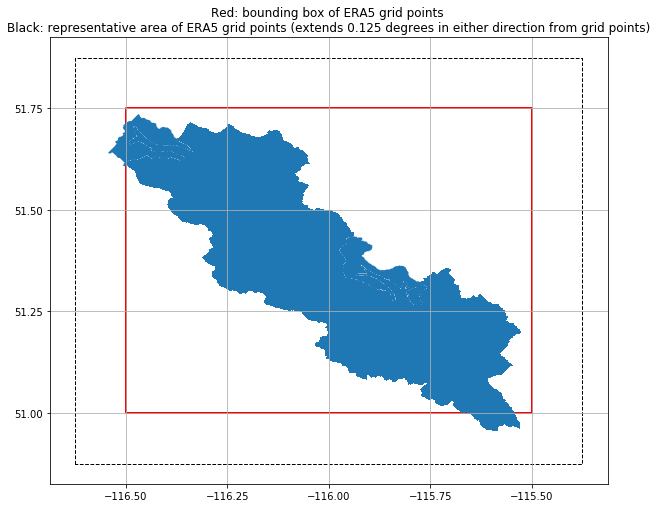

In [123]:
# Make a figure
fig = plt.figure(figsize=(10,10))
ax = fig.gca()

# data
# re-draw the bounding box of the ERA5 data we need
shp_point.plot(ax=ax,facecolor='None',edgecolor='r',linewidth=2);
shp_cells.plot(ax=ax,facecolor='None',edgecolor='k',linestyle='--');
shp.plot(ax=ax);

# grid spacing indicating ERA5 grid points
ax.xaxis.set_major_locator(plticker.MultipleLocator(base=0.25))
ax.yaxis.set_major_locator(plticker.MultipleLocator(base=0.25))
ax.grid(which='major', axis='both', linestyle='-')

# set the legend in the title because why not
ax.set_title('Red: bounding box of ERA5 grid points \nBlack: representative area of ERA5 grid points (extends 0.125 degrees in either direction from grid points)');